# Set-up

In [1]:
#pip install num2words
#!pip install unidecode

In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [4]:
TOP = 50
REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
EXTRA_SW = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb', 'without', 'behind', \
            'within')

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(unidecode.unidecode(col).lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [51]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding="ISO-8859-1", \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())

print(train.info())

cols = list(train.columns)
freq = recap_cols(train, cols)

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 64767087 to 65888323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   53940 non-null  object
 1   Body    53940 non-null  object
 2   Tags    53940 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
None
Dénombrenent des mots
	Title  :  537304 dont  29973 distincts
	Body   : 9090135 dont 1059966 distincts
	Tags   :   53940 dont   8616 distincts


,Title,Body,Tags
64767087,understanding the git data model,"<p>i have recently started reading <a href=""ht...",<git>
63429629,calculator vs sql server giving different results,<p>i have a simple calculation <code>sum(eom_c...,<sql><sql-server>
63072035,what happens to child branches if you merge th...,<p>i think the question is clear but just to e...,<git>
62824936,non-nullable readonly references and empty pri...,<p>some of my c# classes don't have a default ...,<c#>
60928038,string was not recognized as a valid datetime ...,<p>i have this simple line of code : </p>\r\n\...,<c#><.net><datetime><parsing>


# Nettoyage du dataframe

In [53]:
# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    # et des chiffres (1, 0, 2003, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in EXTRA_SW]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

#train['full']  = train.Title + ' ' + train.Body
#cols.append('full')

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
#train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 57.5 sec
Conversion html de "Body" -> OK en 34.3 sec
Nettoyage/lemmatisation de "Body" -> OK en 3.63e+02 sec
Traitement des tags -> OK en 0.0813 sec
Dénombrenent des mots
	Title  :  263148 dont  10369 distincts
	Body   : 1531668 dont  47503 distincts
	Tags   :  119160 dont    309 distincts
8518 groupes de tags distincts


,Title,Body,Tags,nTags
64767087,git data model,read understand git work hood diagram book git...,git,1
63429629,calcul v sql server result,simpl calcul sum eom count result valu calcul ...,sql sql-server,2
63072035,happen child branch merg parent branch master,think question elabor branch branch happen bra...,git,1
62824936,refer default constructor c# result cs8618,c# class default constructor design declar def...,c#,1
60928038,string datetim day week incorrect,simpl line code code day week throw except mon...,.net c# datetime parsing,4


## Nombre de mots dans les Title

In [54]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,53940.000000
mean,4.878532
std,1.866263
min,0.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,18.000000


## Nombre de mots dans les Body

In [55]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,53940.000000
mean,28.395773
std,21.039055
min,0.000000
25%,15.000000
50%,23.000000
75%,36.000000
max,762.000000


In [56]:
backup = train.copy()

# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

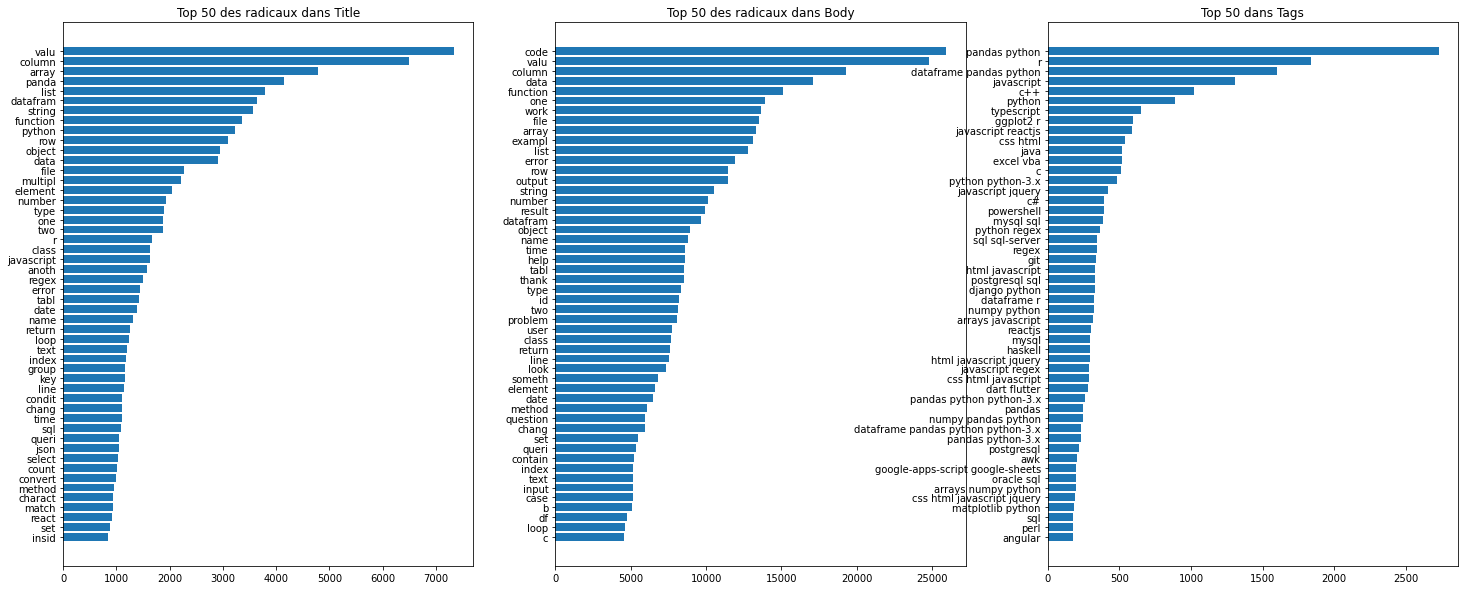

In [57]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in ['Title', 'Body']:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags unitaires

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

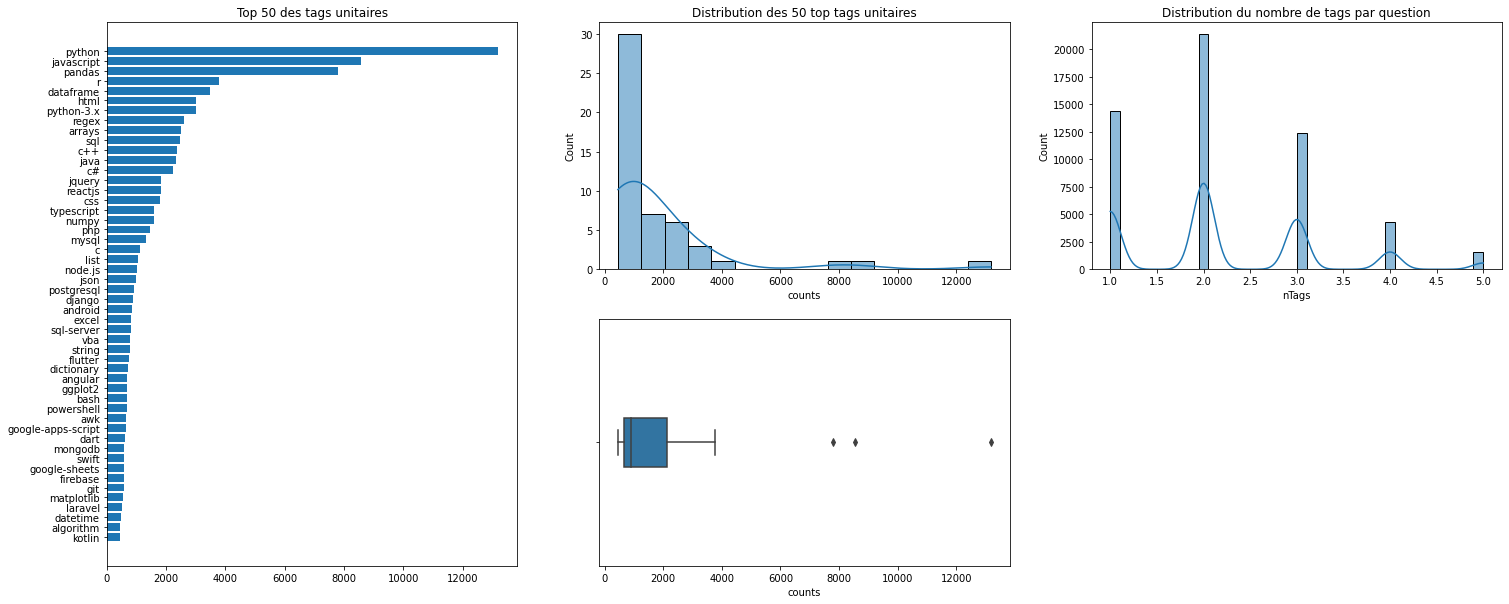

In [58]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [59]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,309.000000
mean,385.631068
std,1114.397167
min,1.000000
25%,39.000000
50%,106.000000
75%,258.000000
max,13187.000000


# Réductions


## 50 top tags des nregistrements avec 1 seul tag

In [60]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   66537 dont   4987 distincts
	Body   :  374642 dont  17983 distincts
	Tags   :   14353 dont    177 distincts
(53940, 4)


,Title,Body,Tags,nTags
64767087,git data model,read understand git work hood diagram book git...,git,1
63072035,happen child branch merg parent branch master,think question elabor branch branch happen bra...,git,1
62824936,refer default constructor c# result cs8618,c# class default constructor design declar def...,c#,1
60374806,delet applic c#,delet applic window process process name error...,c#,1
63451246,gcp extend memori aw,gcp custom machin type choic select allow cust...,amazon-web-services,1


Dénombrenent des mots
	Title  :   61866 dont   4607 distincts
	Body   :  347650 dont  16860 distincts
	Tags   :   13370 dont     50 distincts


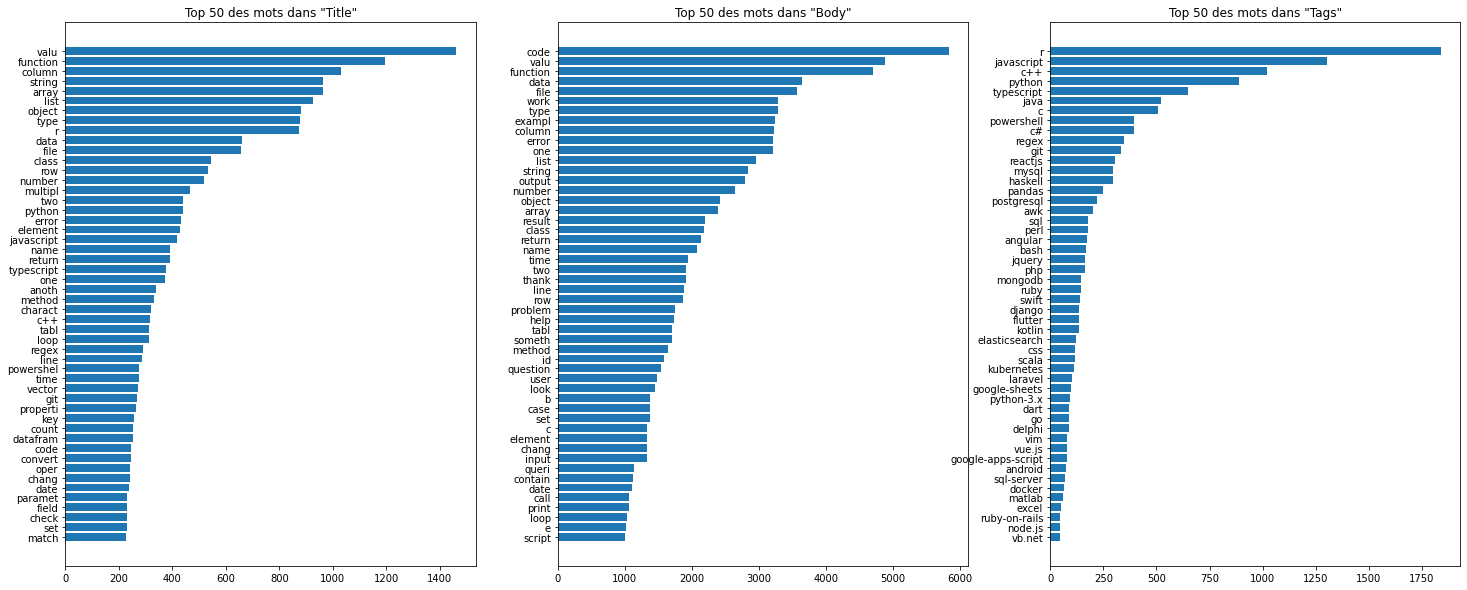

In [61]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:TOP]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Bag of words des 2 mots les plus féquents pour chaque tag unitaire

In [62]:
# Dictionnaire des index des enregistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    for t in c['Tags'].split():
        try:
            dict_Tags['idx'][t].append(i)
        except KeyError:
            dict_Tags['idx'][t] = [i]

In [64]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    list_idx = dict_Tags['idx'][k]
    val = train[train.index.isin(list_idx)]['Title'] + ' ' + train[train.index.isin(list_idx)]['Body'] 
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 284 radicaux distincts restants


Dénombrenent des mots
	Title  :  125501 dont    283 distincts
	Body   :  558162 dont    284 distincts
	Tags   :  119160 dont    309 distincts


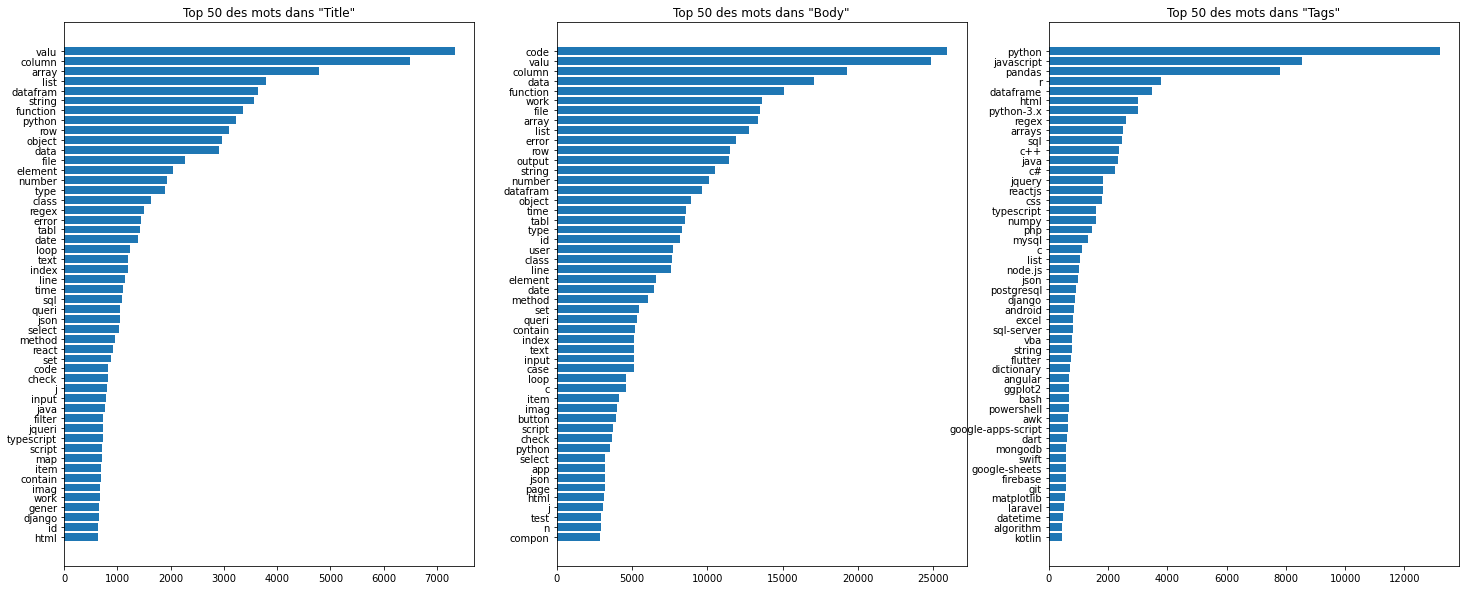

In [65]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Bag of words des 2 mots les plus féquents pour chaque tag

In [66]:
# Dictionnaire des index des enregistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    try:
        dict_Tags['idx'][c['Tags']].append(i)
    except KeyError:
        dict_Tags['idx'][c['Tags']] = [i]

print('{} tags'.format(len(dict_Tags['idx'])))

8518 tags


In [68]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    list_idx = dict_Tags['idx'][k]
    val = train[train.index.isin(list_idx)]['Title'] + ' ' + train[train.index.isin(list_idx)]['Body'] 
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 2031 radicaux distincts restants


Dénombrenent des mots
	Title  :  235606 dont   1835 distincts
	Body   : 1249476 dont   2024 distincts
	Tags   :  119160 dont    309 distincts


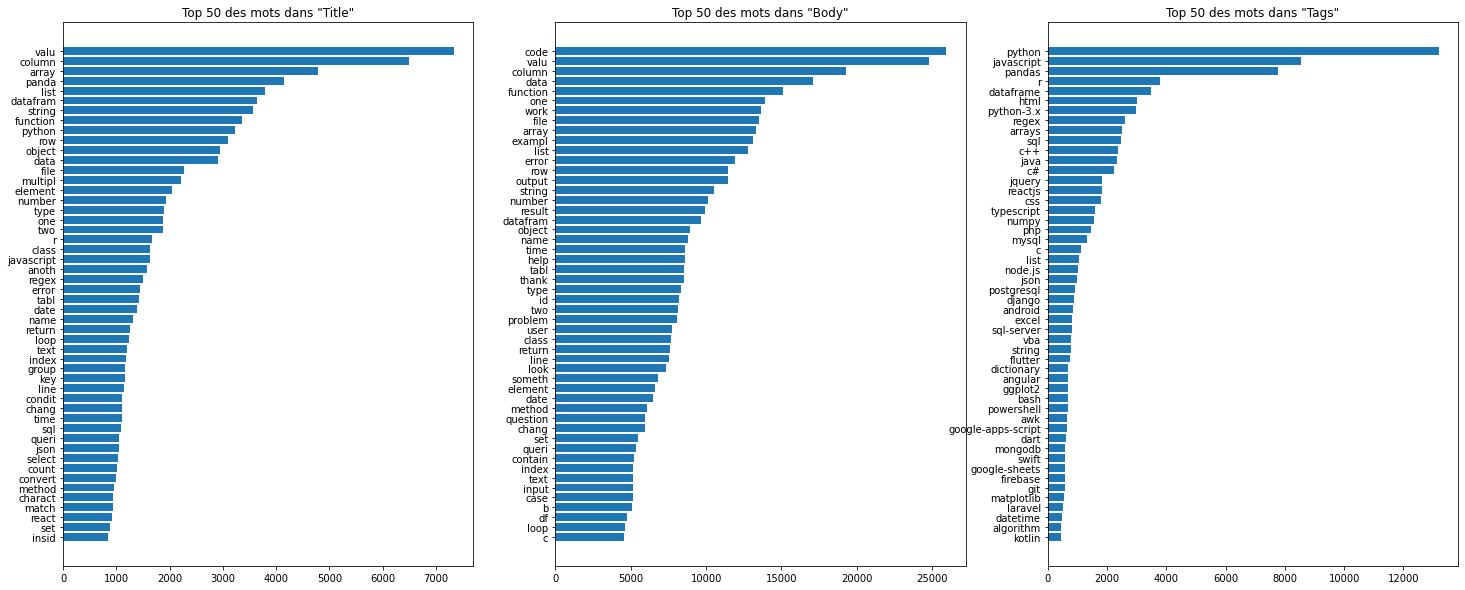

In [69]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

cols = ['Title', 'Body', 'Tags']
freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

## Top tags
Je conserve les 100 tags les plus fréquents

In [70]:
top_tags = [i for i, j in Counter(' '.join(train.Tags).split()).most_common(100)]
top_tags[:10]

['python',
 'javascript',
 'pandas',
 'r',
 'dataframe',
 'html',
 'python-3.x',
 'regex',
 'arrays',
 'sql']

### Création de la nouvelle feature

In [71]:
train['top_tags'] = train.Tags.apply(lambda x: ' '.join([w for w in x.split() \
                                                         if w in top_tags]))
train.head()

,Title,Body,Tags,nTags,top_tags
64767087,git data model,read understand git work hood diagram book git...,git,1,git
63429629,calcul v sql server result,simpl calcul sum eom count result valu calcul ...,sql sql-server,2,sql sql-server
63072035,happen child branch merg parent branch master,think question elabor branch branch happen bra...,git,1,git
62824936,refer default constructor c# result cs8618,c# class default constructor design declar def...,c#,1,c#
60928038,string datetim day week incorrect,simpl line code code day week throw except mon...,.net c# datetime parsing,4,.net c# datetime


### Suppresion des top_tags non renseignés

In [72]:
len(train[train.top_tags == ''])

1361

In [73]:
train.drop(train[train.top_tags == ''].index, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52579 entries, 64767087 to 65888323
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     52579 non-null  object
 1   Body      52579 non-null  object
 2   Tags      52579 non-null  object
 3   nTags     52579 non-null  int64 
 4   top_tags  52579 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


Distribution du nombre de tags par question

In [74]:
train['nTags'] = train.top_tags.apply(lambda x: len(x.split()))
train.nTags.value_counts().to_frame().sort_index()

,nTags
1,17899
2,21367
3,9863
4,2880
5,570


In [77]:
cols.append('top_tags')
freq = recap_cols(train, cols)

Dénombrenent des mots
	Title  :  256593 dont   9998 distincts
	Body   : 1492769 dont  46197 distincts
	Tags   :  117411 dont    306 distincts
	top_tags :  104592 dont    100 distincts


# Export

In [76]:
with open('OC_DS_P6_backup.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(train[['Title', 'Body', 'top_tags']])
    pickler.dump(EXTRA_SW)
    pickler.dump(REGEX)